#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 20

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.11134924, -0.01756312,  0.99362613],
       [-0.98123468, -0.1603195 ,  0.10712684],
       [ 0.15741617, -0.98690891, -0.035085  ]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.000991


In [33]:
Ret.shape

(20, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000226


In [37]:
C1(dx,dy,dz,Ret)

array([[ 2.38261222e-02,  3.58320757e-01,  2.65813937e-01,
        -1.45337631e-03,  3.36269164e+00,  1.65756366e-01,
         9.41244877e-01, -1.90022551e+00,  1.60668266e+00,
        -3.36550644e-01, -6.25231149e+00, -1.39338745e-02,
         6.47231582e+00, -2.75486661e+00,  1.89457871e+00,
        -1.75364027e+00,  5.58671144e-03,  2.82809946e-01,
         3.13441122e+00,  1.30155960e+00],
       [-3.54212127e+00,  9.36791932e-01,  5.17441777e+00,
        -2.57691109e+00,  7.79691391e-01,  1.10712062e+00,
         2.14122083e-02,  2.77461695e-01, -7.61019835e-02,
         5.72582988e-03, -4.71212949e-02, -8.38043847e-02,
        -2.57121759e-01,  1.25743016e+00,  2.54352379e+00,
        -2.27530802e+00, -3.50108648e-01, -1.16739700e+00,
        -3.62512587e-01, -7.11663355e-01],
       [ 3.44230648e+00, -2.36047471e+00,  1.53355033e+00,
         1.67867550e+00, -9.52327961e-02,  1.26049559e+00,
        -7.27772748e-02,  3.15237183e-01, -2.04225738e-01,
        -2.00544661e-02,  6.9

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 1.36738924e+02, -2.03283542e+04,  1.97555137e+04],
       [ 2.05641498e+03,  5.37628069e+03, -1.35468445e+04],
       [ 1.52551521e+03,  2.96961592e+04,  8.80109737e+03],
       [-8.34097599e+00, -1.47889802e+04,  9.63397564e+03],
       [ 1.92986014e+04,  4.47467535e+03, -5.46544249e+02],
       [ 9.51281408e+02,  6.35380280e+03,  7.23402697e+03],
       [ 5.40183629e+03,  1.22885390e+02, -4.17671250e+02],
       [-1.09054587e+04,  1.59236208e+03,  1.80915689e+03],
       [ 9.22080633e+03, -4.36751866e+02, -1.17205844e+03],
       [-1.93147557e+03,  3.28607320e+01, -1.15093261e+02],
       [-3.58822278e+04, -2.70430711e+02,  3.99913951e+01],
       [-7.99669787e+01, -4.80956208e+02,  1.75824464e+03],
       [ 3.71448401e+04, -1.47563050e+03, -5.07390039e+03],
       [-1.58102729e+04,  7.21643438e+03,  2.46240154e+03],
       [ 1.08730515e+04,  1.45973693e+04, -2.36631862e+03],
       [-1.00642010e+04, -1.30580699e+04,  5.13872053e+03],
       [ 3.20623266e+01, -2.00928541e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000396


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000322


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000027


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[ 0.26141661, -1.437854  ,  1.43156224],
       [ 0.42902531,  1.7086844 , -0.16204579],
       [ 0.46189801,  1.51190397, -0.61859587],
       [-0.33643239, -0.67130058, -0.43135597],
       [-1.05306301, -0.69978381,  0.21476745],
       [-1.77456348, -1.28824434,  0.69529586],
       [ 0.83442317, -1.98537835, -0.88299936],
       [-0.45690264,  1.1424738 ,  0.12235696],
       [ 0.67421433,  0.26992434, -0.19466772],
       [-0.00486077,  2.38487927, -1.81697938],
       [-1.9020761 , -2.63809672,  1.59413392],
       [-0.24951657,  0.41992524, -1.39953321],
       [ 1.00396338,  0.32178133,  1.25192523],
       [-0.18173468,  1.75536407,  0.22755773],
       [ 0.3579855 ,  0.96530753, -0.64546264],
       [ 1.84001093, -0.43856926, -0.1253946 ],
       [-1.00397517, -1.20712058,  1.32459765],
       [-1.3476807 , -0.315253  , -0.73138416],
       [-0.11086343,  0.06539401, -0.51692575],
       [-0.60174489, -0.29619955,  0.66861411]])

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000107


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000256


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000518


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[-1.33307006,  1.03420867, -0.02839686],
       [-1.71791892,  1.42046761,  0.16805952],
       [ 0.01734265, -2.01080844,  1.3353967 ],
       [ 1.03128437,  0.45192118,  0.17920373],
       [-0.02816539, -1.49332726,  1.07991429],
       [-1.95436581, -0.80857054,  0.18338846],
       [-0.91870438, -0.39229029, -0.43216577],
       [-0.09226276,  0.40904279, -0.10093789],
       [-0.33022523,  2.07549419, -0.58911915],
       [ 0.43002974, -0.74123413, -1.67301766],
       [ 0.54286411, -0.49036709, -1.95821819],
       [ 0.42743724,  0.45201552,  0.16248381],
       [-0.10360558,  1.86694364,  0.64130457],
       [-1.40350442, -0.79399213,  0.46900976],
       [ 0.05065149, -1.08373235, -0.0548077 ],
       [ 0.27606209,  1.97393089, -1.21970715],
       [-1.25552792,  0.90789691,  0.91192368],
       [ 0.95171019,  1.62931259, -1.32881839],
       [-0.10995424, -0.70206721, -0.30049245],
       [-1.41637967, -0.33533438, -1.72386827]])

In [63]:
def d_s(f,a,b,c,Ret,omega): # here

    fun = f(a,b,c,Ret,omega, None)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 0.02575461, -0.01675066, -0.01909927,  0.00212492,  0.00819602,
         0.01778804,  0.0098198 , -0.00912322, -0.00416804, -0.03769946,
         0.03795967, -0.01635628,  0.00838961, -0.01366134, -0.01444932,
         0.00279624,  0.02272678, -0.0037623 , -0.00523844,  0.0086695 ],
       [-0.14095194,  0.02005948,  0.06605183,  0.04016544, -0.03092149,
        -0.08547685,  0.0958511 , -0.01633634,  0.02551909,  0.18182614,
        -0.17658678,  0.13785251, -0.1163258 , -0.02440372,  0.06781107,
         0.0290186 , -0.14157008,  0.06114638,  0.05074924, -0.07230995],
       [-0.14627446,  0.16716797,  0.14717542, -0.06416504, -0.06056519,
        -0.11297214, -0.20623665,  0.11846823,  0.02094889,  0.23875705,
        -0.24693712,  0.04427827,  0.0231712 ,  0.1773382 ,  0.09339951,
        -0.06046153, -0.11178868, -0.01942372,  0.00754354, -0.02423124]])

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000637


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-1.77648514e-06, -3.55931807e-07,  5.75348691e-07,
        -1.87317537e-07,  1.16730800e-06,  1.47082803e-06,
         2.53669972e-06, -9.33095368e-07, -5.76871739e-07,
        -1.00331370e-06, -3.31539316e-06,  3.04102985e-07,
        -2.54101986e-06,  4.37881426e-07, -1.46587169e-06,
         7.37846583e-07, -6.99470912e-07, -1.48518171e-06,
        -4.94528608e-07, -6.93946458e-07],
       [ 1.14687427e-02,  1.30212937e-02, -3.87152566e-03,
         7.58688842e-03, -3.21928174e-03, -1.36442761e-02,
        -2.12847123e-03, -3.00111561e-03,  4.41336778e-03,
        -6.48449199e-03, -4.46152677e-03, -2.47372462e-03,
         1.39289492e-02,  8.00353259e-03,  6.02885089e-03,
         1.07016807e-02, -5.96883082e-04,  3.71137740e-03,
         4.44501396e-03, -9.70103774e-04],
       [ 6.47587677e-03, -9.42650119e-03, -1.94017461e-03,
        -5.69508100e-03, -8.57214056e-03, -1.21263166e-03,
        -2.34959446e-02,  1.24269495e-02,  1.41369014e-03,
         1.66198142e-02,  3.7

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.36738924e+02, -2.05641498e+03, -1.52551521e+03,
         8.34097599e+00, -1.92986014e+04, -9.51281408e+02,
        -5.40183629e+03,  1.09054587e+04, -9.22080633e+03,
         1.93147557e+03,  3.58822278e+04,  7.99669787e+01,
        -3.71448401e+04,  1.58102729e+04, -1.08730515e+04,
         1.00642010e+04, -3.20623266e+01, -1.62305588e+03,
        -1.79884924e+04, -7.46969471e+03],
       [ 2.03283542e+04, -5.37628069e+03, -2.96961592e+04,
         1.47889802e+04, -4.47467535e+03, -6.35380280e+03,
        -1.22885390e+02, -1.59236208e+03,  4.36751866e+02,
        -3.28607320e+01,  2.70430711e+02,  4.80956208e+02,
         1.47563050e+03, -7.21643438e+03, -1.45973693e+04,
         1.30580699e+04,  2.00928541e+03,  6.69973103e+03,
         2.08047204e+03,  4.08426015e+03],
       [-1.98836783e+04,  1.34186799e+04, -8.92926191e+03,
        -9.76214019e+03,  4.18379706e+02, -7.36219152e+03,
         2.89506707e+02, -1.93732143e+03,  1.04389390e+03,
        -1.30712809e+01, -1.6

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000654


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[ 7.90392778e+01, -7.98363143e+05, -1.32668344e+01],
       [-2.51788236e+01,  1.72603251e+03,  2.52618278e+05],
       [-1.09270971e+02,  1.10536888e+06, -1.62196798e+03],
       [ 1.93533507e+02, -4.44121788e+05, -1.51083835e+06],
       [-1.28990448e+02,  2.13557648e+06, -8.32685080e+05],
       [-7.69374487e+01,  9.44874859e+05, -1.67737543e+05],
       [-6.58010380e+01,  8.50851646e+05, -1.86204245e+05],
       [ 2.11541705e+02, -3.39335773e+06,  1.25663687e+06],
       [ 1.13876047e+02, -1.21757812e+06,  6.73186217e+04],
       [-4.61916675e+01,  4.16144981e+05,  5.04399963e+04],
       [-1.39735868e+02, -3.46408906e+05,  1.75797117e+06],
       [ 5.39670717e+02, -2.72813187e+06, -2.72322458e+06],
       [-6.39823821e+01, -1.68864774e+06,  2.33505264e+06],
       [ 1.35770669e+01, -8.72682764e+04, -4.98763179e+04],
       [-2.65858521e+02,  1.92112567e+06,  7.64352218e+05],
       [ 1.48842334e+01, -2.74061140e+05,  1.23721642e+05],
       [ 1.89530783e-01, -2.08306825e+03

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-6.61482490e+07, -7.87536119e+03,  7.98297659e+07],
       [-1.38060361e+06,  2.52616911e+07, -1.72739924e+05],
       [ 1.71892272e+08, -1.45179461e+05, -1.10519871e+08],
       [-2.32213634e+08, -1.51106824e+08,  4.43891908e+07],
       [ 3.11738818e+05, -8.32684772e+07, -2.13557618e+08],
       [-2.78022146e+08, -1.68012785e+07, -9.45150086e+07],
       [-7.82236951e+08, -1.86978659e+07, -8.51626022e+07],
       [-7.53137839e+08,  1.25589126e+08,  3.39261216e+08],
       [ 1.13044946e+08,  6.74305362e+06,  1.21769003e+08],
       [-1.49781146e+08,  5.02917130e+06, -4.16293257e+07],
       [ 9.25393066e+07,  1.75806278e+08,  3.46500515e+07],
       [-5.99005276e+08, -2.72381759e+08,  2.72753888e+08],
       [ 1.68416888e+07,  2.33506932e+08,  1.68866441e+08],
       [-1.04261693e+07, -4.98866398e+06,  8.72579550e+06],
       [-1.01762615e+08,  7.64251473e+07, -1.92122641e+08],
       [ 6.57790685e+07,  1.23786763e+07,  2.74126258e+07],
       [-2.33054702e+08, -6.20994309e+03

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000218


In [76]:
Re_b(Ret).shape

(20, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000762


In [82]:
d_me_

array([[ 9.37245060e-03,  6.72244577e+01, -1.61903864e+02],
       [-2.39831981e-03,  1.10554608e+01,  1.31706552e+01],
       [ 1.96154728e-02,  1.07670144e+02, -3.05821696e+02],
       [ 8.47160221e-03,  9.34952799e+01, -1.79076079e+02],
       [ 1.48106434e-02, -2.71740179e+02,  1.22143936e+02],
       [ 6.66014427e-03,  2.92459025e+02, -3.59751428e+02],
       [-6.11377989e-03,  6.30094334e+02, -5.68367793e+02],
       [-1.42451854e-02, -8.17766672e+00,  1.52076110e+02],
       [-4.61052989e-02,  9.41469554e+01,  3.71581885e+02],
       [-1.11317302e-02,  2.29149746e+02, -1.16713960e+02],
       [ 6.83039099e-02, -6.86639005e+02, -3.29952993e+00],
       [-1.28715813e-02,  4.24722846e+01,  8.75481030e+01],
       [-4.11621216e-02, -1.23748178e+02,  5.39554455e+02],
       [ 1.83368190e-02, -1.43025836e+02, -4.21966650e+01],
       [-7.58638729e-02, -2.36650310e+00,  7.68707073e+02],
       [-8.58596488e-04,  1.29717345e+02, -1.21050789e+02],
       [-9.38355514e-06,  3.74667399e+02

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.36738924e+02, -2.05641498e+03, -1.52551521e+03,
         8.34097599e+00, -1.92986014e+04, -9.51281408e+02,
        -5.40183629e+03,  1.09054587e+04, -9.22080633e+03,
         1.93147557e+03,  3.58822278e+04,  7.99669787e+01,
        -3.71448401e+04,  1.58102729e+04, -1.08730515e+04,
         1.00642010e+04, -3.20623266e+01, -1.62305588e+03,
        -1.79884924e+04, -7.46969471e+03],
       [ 2.03283542e+04, -5.37628069e+03, -2.96961592e+04,
         1.47889802e+04, -4.47467535e+03, -6.35380280e+03,
        -1.22885390e+02, -1.59236208e+03,  4.36751866e+02,
        -3.28607320e+01,  2.70430711e+02,  4.80956208e+02,
         1.47563050e+03, -7.21643438e+03, -1.45973693e+04,
         1.30580699e+04,  2.00928541e+03,  6.69973103e+03,
         2.08047204e+03,  4.08426015e+03],
       [-1.98836783e+04,  1.34186799e+04, -8.92926191e+03,
        -9.76214019e+03,  4.18379706e+02, -7.36219152e+03,
         2.89506707e+02, -1.93732143e+03,  1.04389390e+03,
        -1.30712809e+01, -1.6

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=30

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617, 3150635.90893617])

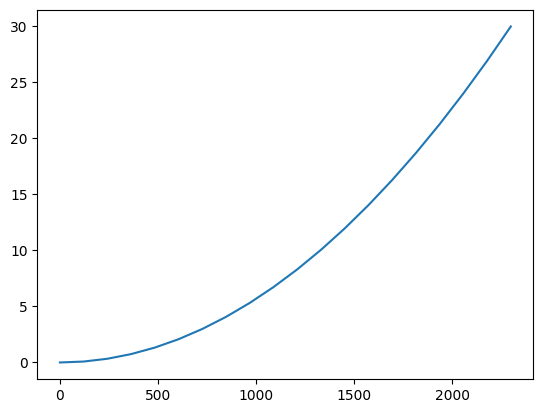

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0*9.81,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0,0,0,0,0])

    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [101]:
q0

array([0.00000000e+00, 1.20965559e+02, 2.41931119e+02, 3.62896678e+02,
       4.83862238e+02, 6.04827797e+02, 7.25793357e+02, 8.46758916e+02,
       9.67724476e+02, 1.08869004e+03, 1.20965559e+03, 1.33062115e+03,
       1.45158671e+03, 1.57255227e+03, 1.69351783e+03, 1.81448339e+03,
       1.93544895e+03, 2.05641451e+03, 2.17738007e+03, 2.29834563e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root_ = root(static_func, q0)

In [103]:
root_

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
       x: [ 0.000e+00  1.210e+02 ...  0.000e+00  0.000e+00]
  method: hybr
    nfev: 491
    fjac: [[ 0.000e+00  0.000e+00 ... -4.199e-17 -3.987e-17]
           [ 0.000e+00  0.000e+00 ...  1.091e-16  1.036e-16]
           ...
           [ 0.000e+00  0.000e+00 ...  3.547e-11 -3.736e-11]
           [ 0.000e+00  0.000e+00 ... -1.366e-13  1.012e-13]]
       r: [-4.698e+02 -4.698e+02 ...  0.000e+00 -0.000e+00]
     qtf: [-1.066e-01 -1.486e+00 ...  0.000e+00  0.000e+00]

In [104]:
x0_,z0_=root_.x[:node_N],root_.x[4*node_N:5*node_N]

In [105]:
q0=root_.x

In [106]:
q0

array([0.00000000e+00, 1.20965559e+02, 2.41931119e+02, 3.62896678e+02,
       4.83862238e+02, 6.04827797e+02, 7.25793357e+02, 8.46758916e+02,
       9.67724476e+02, 1.08869004e+03, 1.20965559e+03, 1.33062115e+03,
       1.45158671e+03, 1.57255227e+03, 1.69351783e+03, 1.81448339e+03,
       1.93544895e+03, 2.05641451e+03, 2.17738007e+03, 2.29834563e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

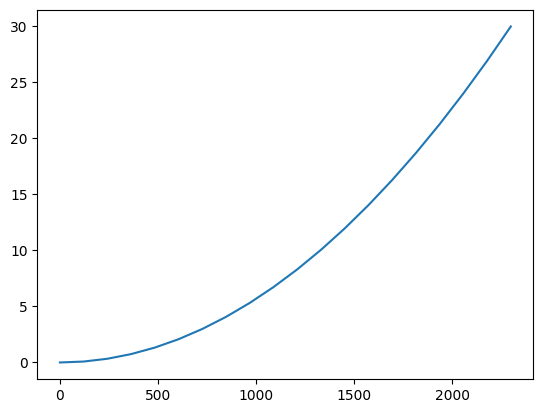

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
        
        
        
#     print(vessel_movement)
    glob_force=np.dot(K, np.array(vessel_movement))
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    
#     return glob_force
#     print(glob_force)
#     print(np.linalg.inv(K)@glob_force)

    F=np.zeros(len(coord)*6)
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)),
        bc_val=[0]*18,
        vessel_movement=[ -0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                       ],
        coefs=[1,1,1,1,1,1])

In [113]:
-0.0705e-4, -0.0007e-4, 0.1418e-4, 0.0145e-4, 0.0175e-4,0.0114e-4

(-7.05e-06, -7e-08, 1.418e-05, 1.45e-06, 1.75e-06, 1.14e-06)

In [114]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [115]:
f

array([-9.99786375e+00, -3.59333333e-03,  2.00042617e+01,  5.25000000e-05,
        1.75000000e-05,  3.18500000e-04,  9.87000000e+00, -3.06133333e-02,
       -1.07846667e-01, -2.03000000e-03, -1.74020000e-01,  2.99600000e-02,
        9.03000000e-02, -3.92933333e-02, -1.98520000e+01,  3.86400000e-02,
        1.23200000e-01, -1.59600000e-03,  3.75637500e-02,  7.35000000e-02,
       -4.44150000e-02, -9.64425000e-02, -1.83750000e-03, -8.70975000e-02])

In [116]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e6, G=84e6,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    return np.array(fors), np.array(mom), np.array(angle)

In [117]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [118]:
fors

array([[-1.51083061e+03,  1.27142468e+01, -1.69792205e+01],
       [ 5.84986992e-09, -4.59340299e-08, -5.99316081e-08],
       [ 6.15400495e-08, -3.87467480e-08,  4.73069122e-08],
       [ 9.82254278e-09,  1.83912481e-08,  4.18613126e-08],
       [-1.38301402e-07, -1.40273187e-07, -1.32263267e-07],
       [ 1.31782144e-07, -4.46525519e-08,  1.08171662e-07],
       [ 6.70552254e-08,  1.39800250e-07,  5.44678187e-08],
       [-9.91858542e-08, -6.34736654e-08,  4.33938112e-08],
       [-2.42143869e-08,  1.59488991e-08,  1.30923581e-07],
       [ 1.04308128e-07,  8.30623321e-08, -7.71833584e-08],
       [-1.15483999e-07, -3.30473995e-08,  9.12114047e-08],
       [ 0.00000000e+00, -1.17653012e-08, -6.73462637e-08],
       [-1.00582838e-07, -4.66825441e-08, -1.35041773e-08],
       [-1.49011612e-08, -1.57160684e-09, -1.69966370e-08],
       [ 2.53319740e-07,  6.69388101e-10,  8.61473382e-09],
       [-1.55808283e-07,  2.04380501e-09, -2.68851692e-09],
       [-7.43316715e-08,  4.54927527e-09

### Vessle Simulation

In [119]:
sampleTime = 0.0005              # sample time [seconds]
N = 220000                      # number of samples

In [120]:
N*sampleTime

110.0

In [121]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [122]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [123]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

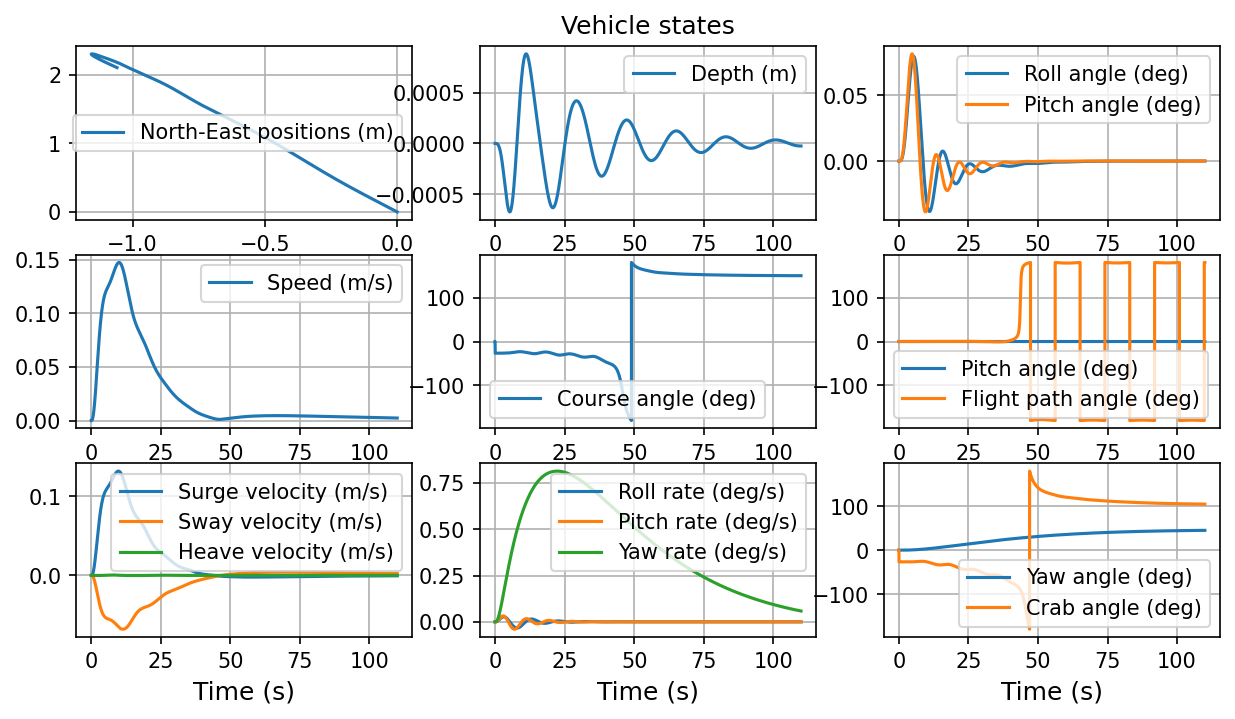

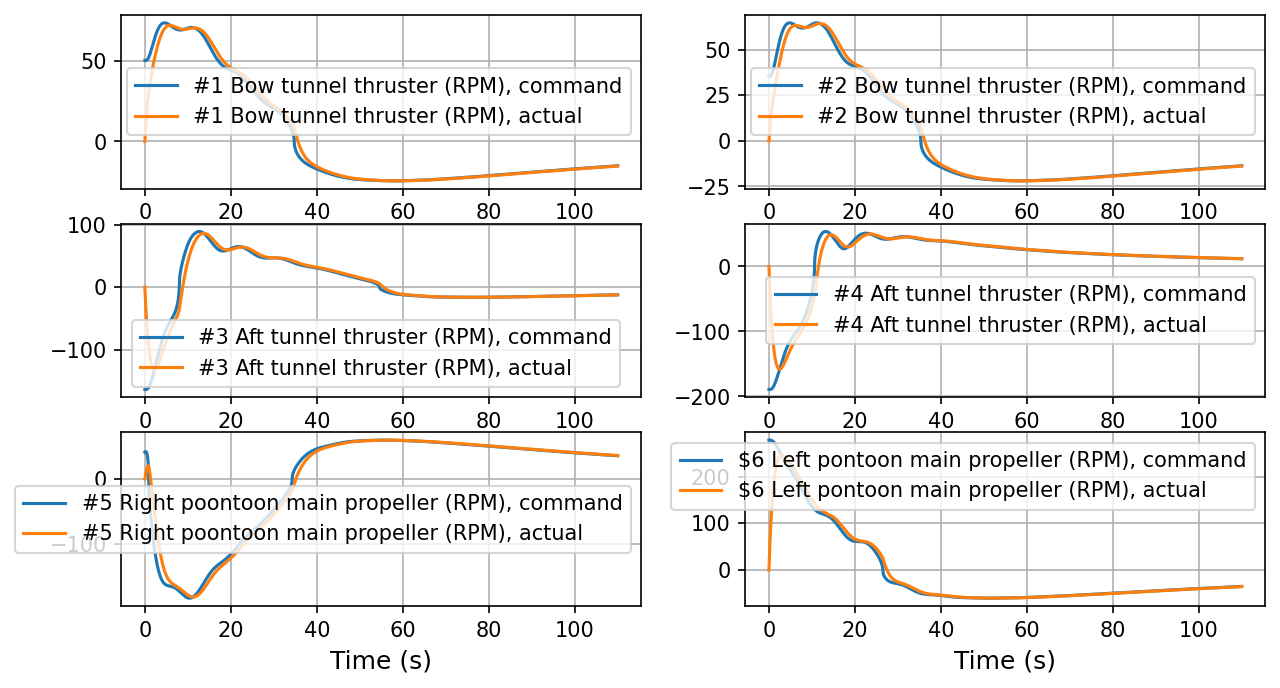

In [124]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [125]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

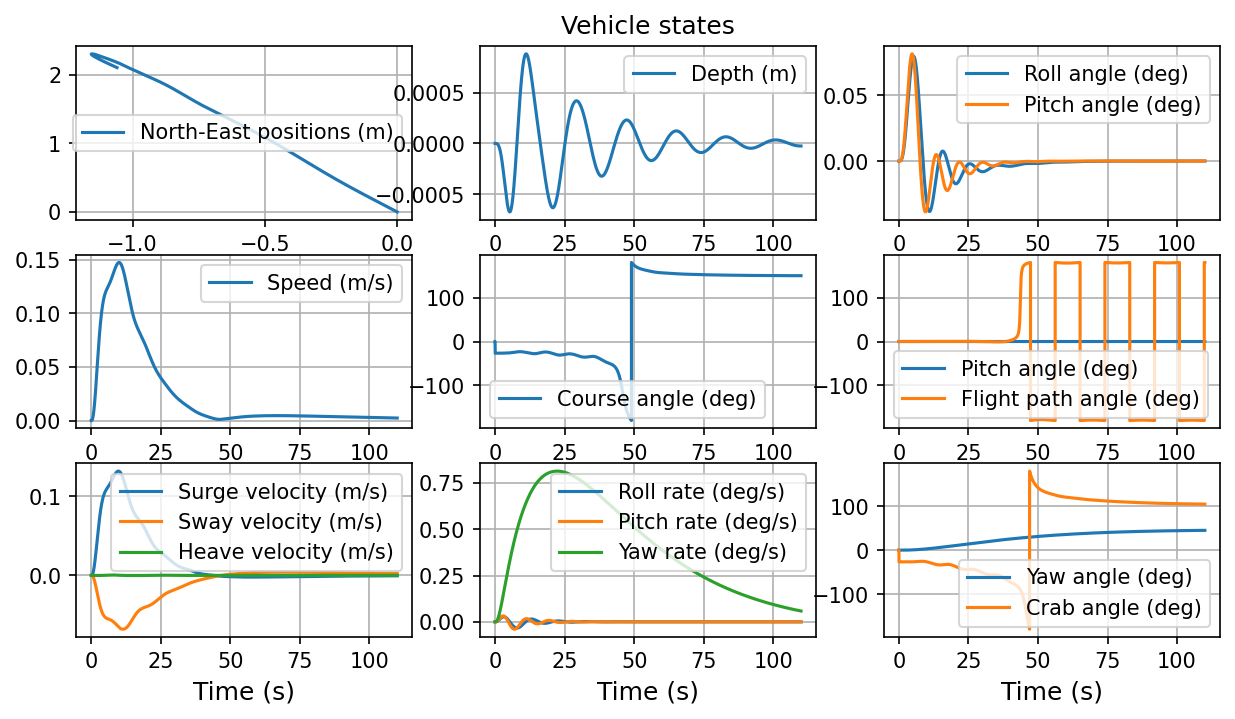

In [126]:
plotVehicleStates(simTime, simData, 3)

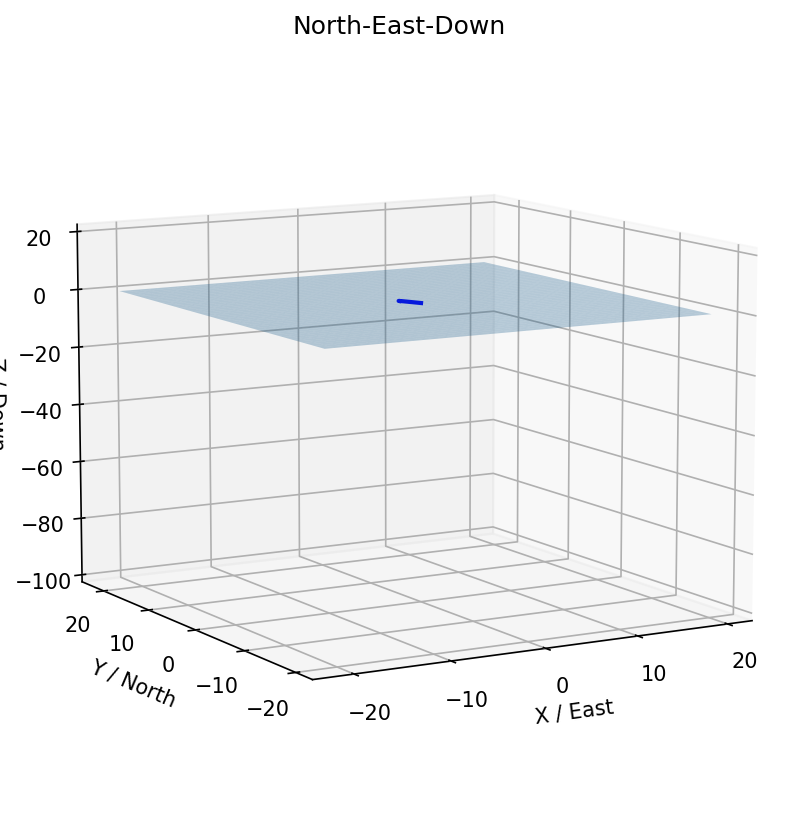

In [127]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [128]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [129]:
idx=1/0.01

In [130]:
idx

100.0

In [131]:
ssa(simData[:, 3][int(idx)])

2.8009106145532314e-10

In [132]:
ssa(simData[:, 4][int(idx)])

3.844453644319401e-10

In [133]:
ssa(simData[:, 5][int(idx)])

8.806546603068455e-10

In [134]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [135]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0) # here new
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [136]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(250)]
        self.wall_clock = datetime.now()

In [137]:
def grayscott1d(t, Q, coefs, T):

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t) # here new

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    
    del_t = abs(t-T.my_t)
    
#     if del_t<1e-7: # here new
#         del_t=1e-6
    
    vessel_movement[0] = u_ve*del_t
    vessel_movement[1] = v_ve*del_t 
    vessel_movement[2] = -w_ve*del_t 
    vessel_movement[3] = p_ve*del_t 
    vessel_movement[4] = q_ve*del_t 
    vessel_movement[5] = r_ve*del_t
    
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)

#     φ,θ,ψ=angle.T 
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
        + Z2
        +Z0
       )

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [138]:
tspan = (0., 100)
T_ = MyTime()

In [139]:
coefs = [1, 1, 1, 1, 1, 1]

In [140]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  3.1484223583397536e-05  Iteration wall clock time:  0:00:00.754240
Physical time:  1.0527275729026906  Iteration wall clock time:  0:00:08.114289
Physical time:  2.094088715018487  Iteration wall clock time:  0:00:03.465849
Physical time:  3.022183230520865  Iteration wall clock time:  0:00:09.549721
Physical time:  4.007451814107309  Iteration wall clock time:  0:00:04.744209
Physical time:  5.041416075271102  Iteration wall clock time:  0:00:04.985468
Physical time:  6.010933279473639  Iteration wall clock time:  0:00:04.638912
Physical time:  7.045638379790737  Iteration wall clock time:  0:00:04.298009
Physical time:  8.044713959293128  Iteration wall clock time:  0:00:04.068824
Physical time:  9.119355578674602  Iteration wall clock time:  0:00:03.706449
Physical time:  10.009413078515292  Iteration wall clock time:  0:00:03.763368
Physical time:  11.098954914614547  Iteration wall clock time:  0:00:02.812177
Physical time:  12.135527343601185  Iteration wall clock

### Results

In [141]:
fin=us

In [142]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.148e-03 ...  9.662e+01  1.000e+02]
        y: [[ 0.000e+00  3.081e-15 ...  2.472e+00  2.568e+00]
            [ 1.210e+02  1.210e+02 ...  1.210e+02  1.210e+02]
            ...
            [ 0.000e+00 -1.381e-05 ...  8.396e-04 -1.054e-03]
            [ 0.000e+00 -1.540e-05 ...  9.070e-04 -1.141e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 368
     njev: 0
      nlu: 0

In [143]:
t=fin.t

In [144]:
fin=fin.y.T

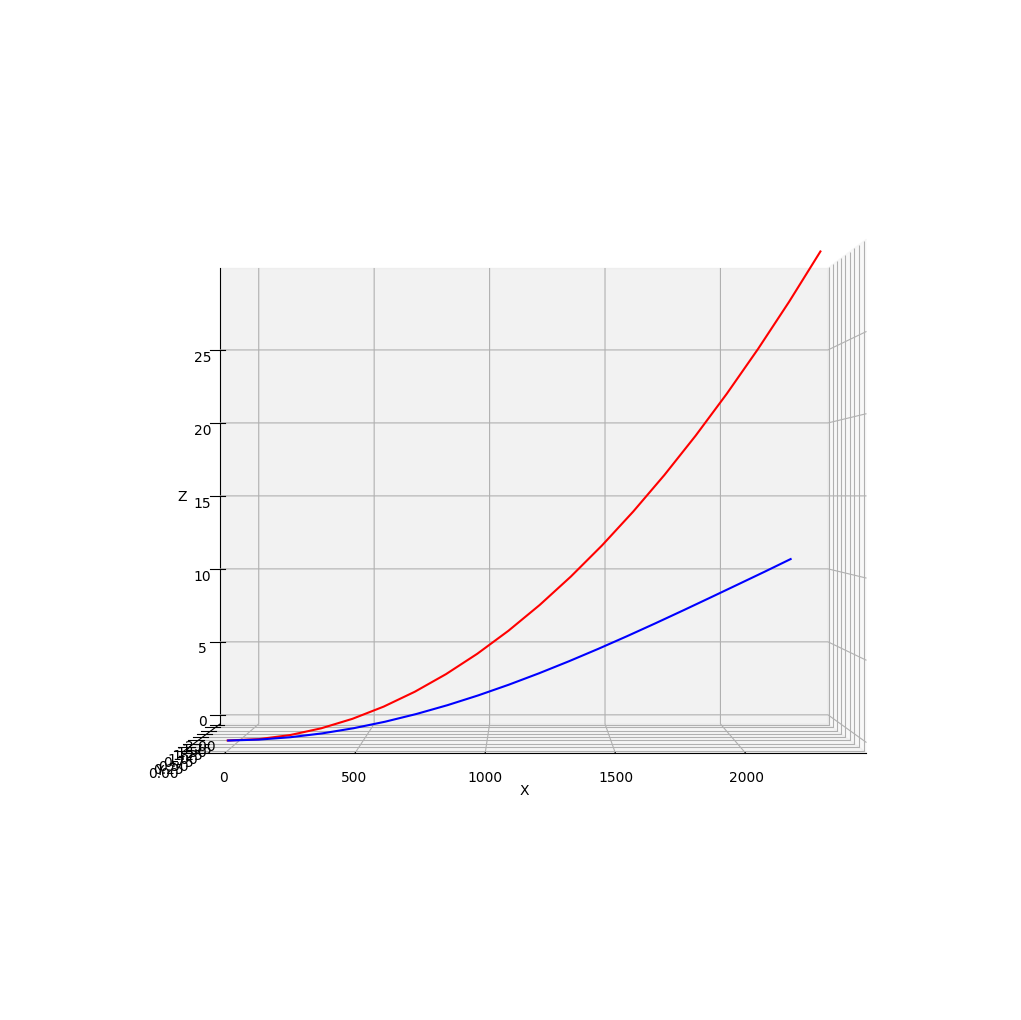

In [145]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [146]:
X,Y,Z

(array([   2.5678187 ,  120.96554216,  241.93111173,  362.89668959,
         483.86227698,  604.82787568,  725.79348802,  846.75911683,
         967.72476546, 1088.6904377 , 1209.65613783, 1330.62187054,
        1451.58764093, 1572.55345448, 1693.51931708, 1814.48523495,
        1935.45121465, 2056.41726309, 2177.3833875 , 2295.76723327]),
 array([-0.0056653 ,  0.00592218,  0.03079259,  0.06839723,  0.11841891,
         0.18042432,  0.25387539,  0.33814296,  0.43252227,  0.53624941,
         0.64851811,  0.76849621,  0.89534123,  1.02821466,  1.16629453,
         1.30878617,  1.45493105,  1.6040136 ,  1.75536629,  1.90802673]),
 array([2.34587169e-03, 5.00256093e-02, 1.74737266e-01, 3.77320308e-01,
        6.56146332e-01, 1.00851737e+00, 1.43076222e+00, 1.91835950e+00,
        2.46608022e+00, 3.06814236e+00, 3.71836955e+00, 4.41034698e+00,
        5.13756829e+00, 5.89356885e+00, 6.67204179e+00, 7.46693505e+00,
        8.27252854e+00, 9.08349185e+00, 9.89492374e+00, 1.07032677e+01]))

In [147]:
X0,Y0,Z0

(array([   0.        ,  120.9655595 ,  241.93111899,  362.89667849,
         483.86223798,  604.82779748,  725.79335697,  846.75891647,
         967.72447596, 1088.69003546, 1209.65559495, 1330.62115445,
        1451.58671394, 1572.55227344, 1693.51783294, 1814.48339243,
        1935.44895193, 2056.41451142, 2177.38007092, 2298.34563041]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.        ,  0.08306948,  0.33227809,  0.74762628,  1.32911485,
         2.0767449 ,  2.99051782,  4.07043536,  5.31649953,  6.7287127 ,
         8.30707753, 10.05159699, 11.96227438, 14.0391133 , 16.28211766,
        18.69129171, 21.26663997, 24.00816732, 26.91587892, 29.98978026]))

In [148]:
us=fin.T

In [149]:
us.shape

(240, 58)

In [150]:
12*50

600

In [151]:
us.T[:,4*node_N+49]

array([ 0.00000000e+00,  1.07129832e-14,  1.27004596e-12,  6.35932895e-11,
       -2.64197139e-09, -1.04656357e-08, -2.23029695e-08, -3.55961188e-08,
       -4.89934204e-08, -6.19692752e-08, -7.43059272e-08, -8.58639888e-08,
       -9.65024277e-08, -1.06060867e-07, -1.14368482e-07, -1.21268834e-07,
       -1.26655596e-07, -1.30513018e-07, -1.32953450e-07, -1.34245907e-07,
       -1.34835559e-07, -1.35361175e-07, -1.36680508e-07, -1.39910929e-07,
       -1.46482555e-07, -1.58177689e-07, -1.77079520e-07, -2.05270443e-07,
       -2.44086139e-07, -2.92983567e-07, -3.48692606e-07, -4.05298355e-07,
       -4.54239777e-07, -4.85494847e-07, -4.93285148e-07, -4.89854396e-07,
       -5.15046786e-07, -6.17130610e-07, -7.53855212e-07, -7.97031061e-07,
       -7.80708556e-07, -7.82032979e-07, -8.91079560e-07, -1.04544609e-06,
       -1.13975160e-06, -1.13433924e-06, -1.10089702e-06, -1.16903919e-06,
       -1.32506155e-06, -1.44109833e-06, -1.44129638e-06, -1.37442870e-06,
       -1.39948586e-06, -

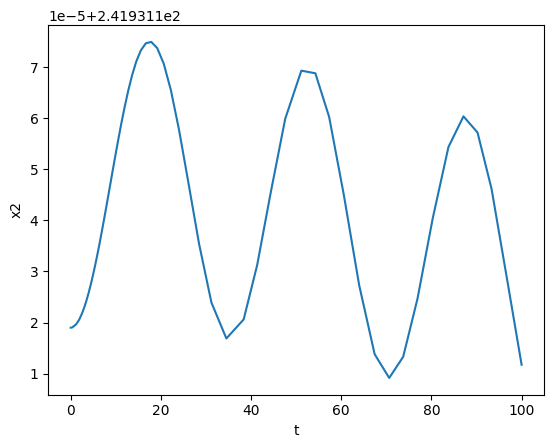

In [152]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

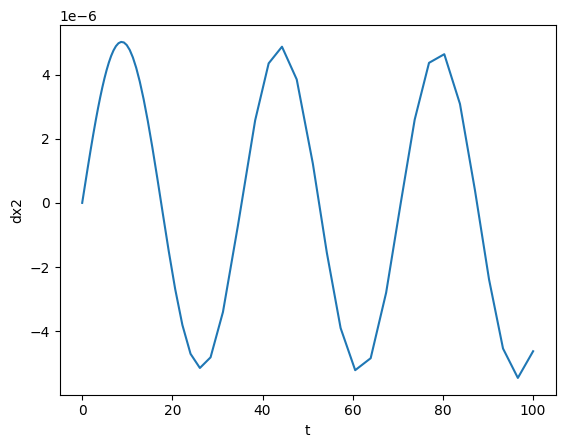

In [153]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

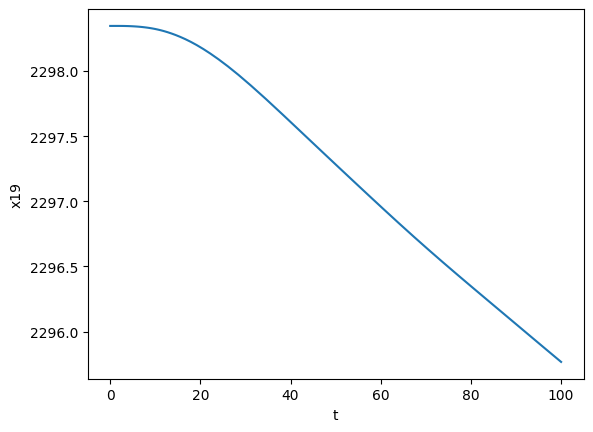

In [154]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x19')
plt.show()

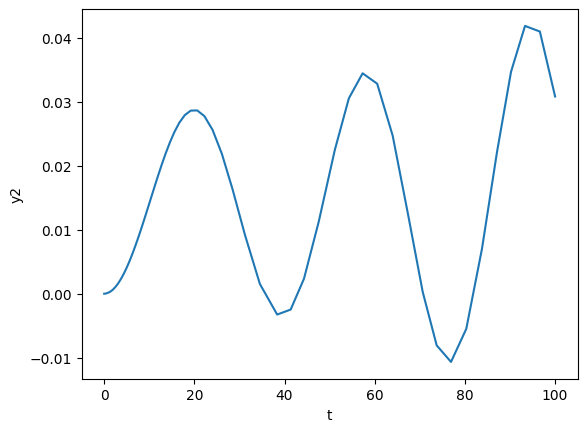

In [155]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

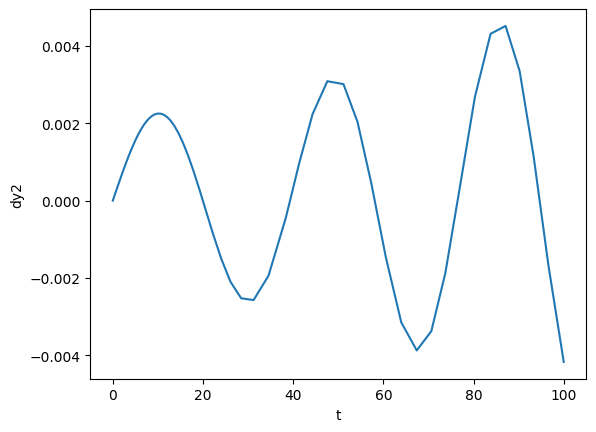

In [156]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

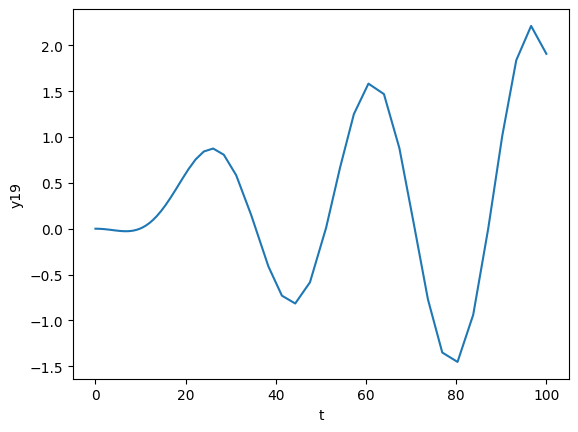

In [157]:
plt.plot(t,us.T[:,2*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('y19')
plt.show()

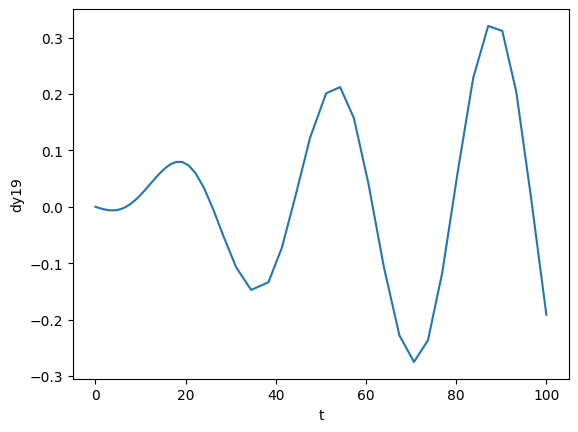

In [158]:
plt.plot(t,us.T[:,3*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('dy19')
plt.show()

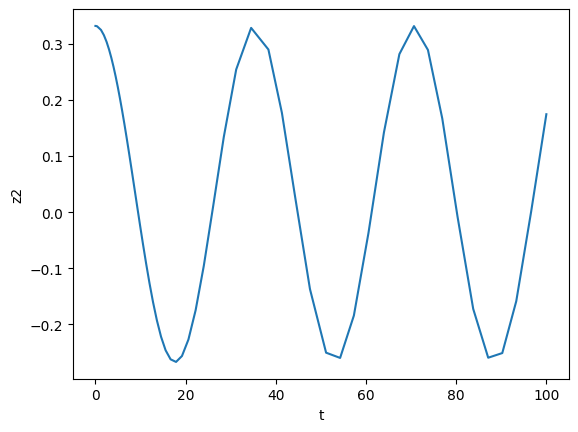

In [159]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

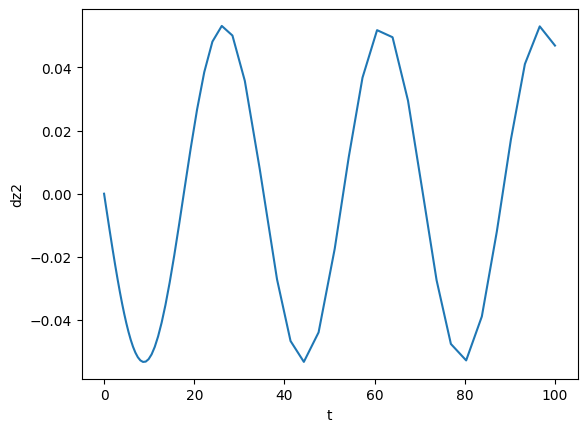

In [160]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

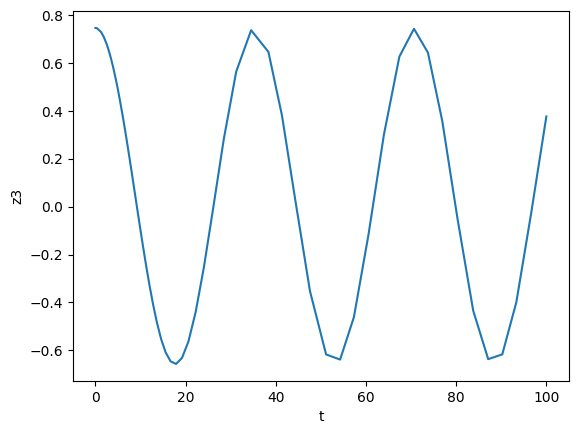

In [161]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

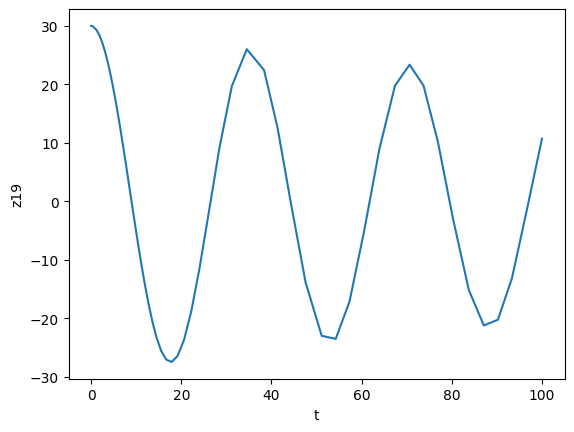

In [162]:
plt.plot(t,us.T[:,4*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('z19')
plt.show()

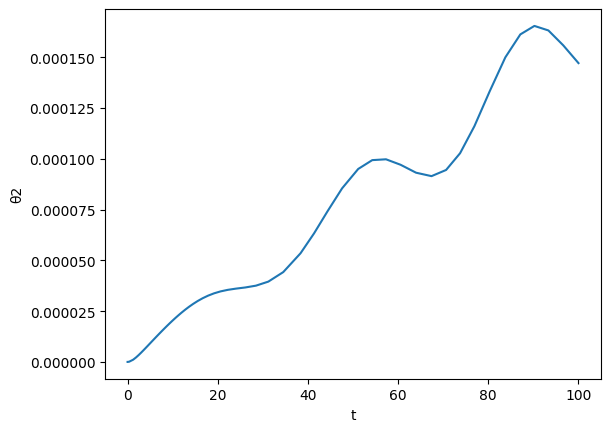

In [163]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

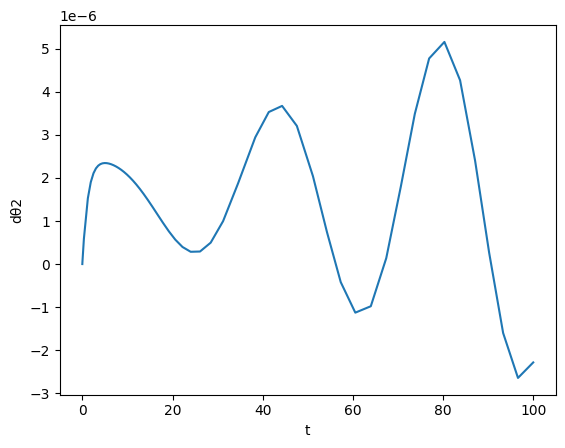

In [164]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

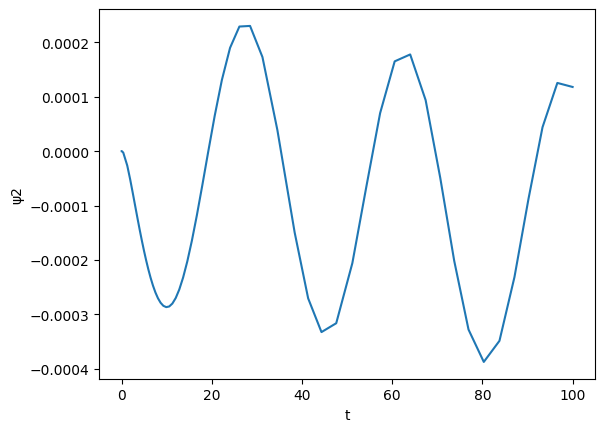

In [165]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

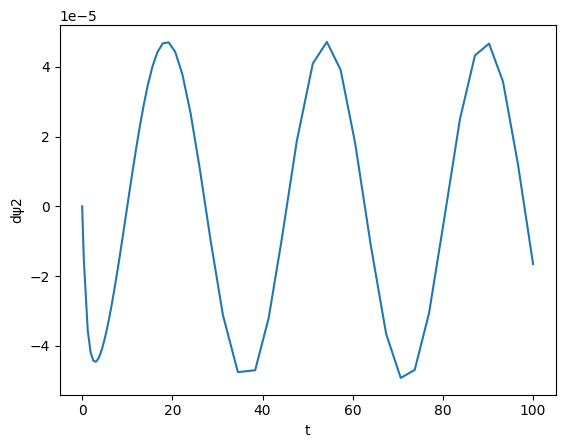

In [166]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

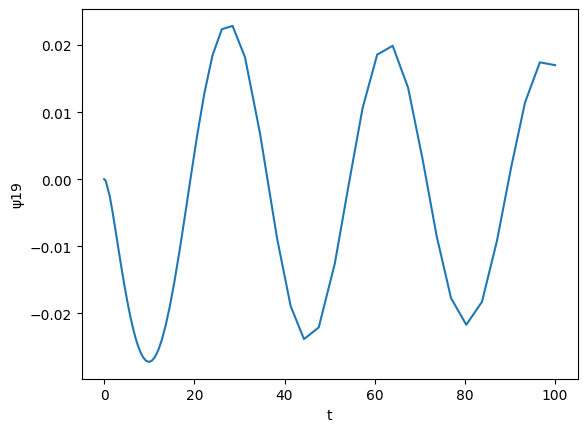

In [167]:
plt.plot(t,us.T[:,10*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('ψ19')
plt.show()